## Final Project Submission

Please fill out:
* Student name: **Raymond Willey**
* Student pace: **Self Paced**
* Scheduled project review date/time: 
* Instructor name: **Eli Thomas**
* Blog post URL:

# Analyzing Presidential Speeches using Artificial Neural Networks
When building NLP classifiers, the goal is usually to identify the class of new, unseen data. This project aims to take this one step further by not only identifying the correct speaker of presidential quotes, but to demonstrate how such an approach can provide to not just the differences, but similarities between presidents.

All data for this project can be found in the folder labeled *Corpus of Presidential Speeches,* which contains over 1,000 raw text files, each of which represents a single speech given by a president. Also included are the general campaign speeches for Donald Trump and Hillary Clinton, though the data does not contain speeches given by Trump since taking office. The original corpus was can be accessed from [The Grammar Lab](http://www.thegrammarlab.com/?nor-portfolio=corpus-of-presidential-speeches-cops-and-a-clintontrump-corpus).

The term *speech* is broadly defined by The Grammar Lab, and may include other forms of public speaking, including debate transcripts. For purposes of this analysis, context of public speech is of little concern, so the corpora was accepted as is.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, string, re
import datetime
import warnings

warnings.filterwarnings('ignore')
np.random.seed(123)

## 1. Select Presidents for Comparison
For the purposes of this project, two presidents will be compared at a time to start building an intuition around interpretation the results. This was primarily due to resource constraints, though nothing inherently prevents us from comparing multiple presidents if so desired. 

The first task is to build a function that allows us to select which two presidents we would like to compare, as well as the vocabulary size for each sample. Ideally, we would like our model to be able to identify the speaker within a few lines without having to read an entire speech. This is particularly important for presidents that gave relatively few speeches.

In [2]:
def get_presidents():
    # Create dictionary with each key representing an index number, and each value representing a president name
    # Names are taken from directory of folders, each of which contains the corpus of speeches for that individual
    
    i=1
    selection_index = {}
    for pres in sorted(list(os.listdir('Corpus of Presidential Speeches/')))[1:]:
        print(f'{i}:\t{pres.title()}')
        selection_index[i] = pres
        i += 1
    
    # Get input from user to choose presidents to compare, along with minimum vocabulary size for each sample
    selections = [input('\n\nEnter the number of the first president/candidate you would like to compare:\t')]
    selections.append(input('Enter the number of the second president/candidate you would like to compare:\t'))
    selections = [selection_index[int(selections[0])], selection_index[int(selections[1])]]
    num_words = int(input('What is the minimum number of words that should be included in each sample?\t'))
    print(f'\n\nSelection 1:\t\t{selections[0].title()}\nSelection 2:\t\t{selections[1].title()}\nVocabulary Size:\t{num_words}')
    return sorted(selections, reverse=True), num_words

For initial comparison, it will be best to use two individuals known to be well understood and very different from one another, as this will allow for an improved ability to gauge performance and identify logical errors in the code. As such, campaign speeches from Donald Trump and Hillary Clinton.

Minimum word count for each sample to be set at 50, representing a general approximation of paragraph length. This should also provide clear and concise examples, making it easier to interpret results. However, any number of words may be selected.

In [3]:
selections, num_words = get_presidents()

1:	Adams
2:	Arthur
3:	Bclinton
4:	Bharrison
5:	Buchanan
6:	Bush
7:	Carter
8:	Cleveland
9:	Coolidge
10:	Eisenhower
11:	Fdroosevelt
12:	Fillmore
13:	Ford
14:	Garfield
15:	Grant
16:	Gwbush
17:	Harding
18:	Harrison
19:	Hayes
20:	Hclinton
21:	Hoover
22:	Jackson
23:	Jefferson
24:	Johnson
25:	Jqadams
26:	Kennedy
27:	Lbjohnson
28:	Lincoln
29:	Madison
30:	Mckinley
31:	Monroe
32:	Nixon
33:	Obama
34:	Pierce
35:	Polk
36:	Reagan
37:	Roosevelt
38:	Taft
39:	Taylor
40:	Truman
41:	Trump
42:	Tyler
43:	Vanburen
44:	Washington
45:	Wilson




Enter the number of the first president/candidate you would like to compare:	 20
Enter the number of the second president/candidate you would like to compare:	 41
What is the minimum number of words that should be included in each sample?	 50




Selection 1:		Hclinton
Selection 2:		Trump
Vocabulary Size:	50


## 2. Parse Text and Save Samples to Dataframe

In [4]:
# Start timer to get total time for running all code
t0 = datetime.datetime.now()

# Save selections to variables
p1, p2 = sorted([selections[0], selections[1]])

# Create variable that identifies directory containing speech corpora
lvl1 = 'Corpus of Presidential Speeches/'

# Create dictionary to store samples. Will be converted to dataframe later.
speech_dict = {'president': [], 'name': [], 'text': []}

# Create dictionaries to keep track of labels and get speech count
labels_index = {}
speech_count = {}

# Iterate through each speech of selected presidents and save results to dictionaries created above
i=0
for folder in sorted(os.listdir(lvl1)):
    if folder in selections:
        labels_index[i] = folder.lower()
        speech_count[folder] = [0]
        
        for file in os.listdir(lvl1 + folder):
            speech_count[folder][0] += 1
            
            with open(f'{lvl1}{folder}/{file}', 'r') as f:
                data = f.read()
                
                # Remove tags for date, title, etc. and select punctuation
                no_tags = re.sub('<[^>]+>', '', data)
                no_line_breaks = no_tags.replace('\n', ' ')
                no_ellipses = no_line_breaks.replace('...', ' ')
                no_dashes = no_ellipses.replace('-', ' ')
                
                # Split data into sentences
                sentences = no_dashes.split('. ')
                
                # Create samples based on word count selection per sample
                # Sentences added to single sample until min word count is reached
                while len(sentences) > 0:
                    text = []
                    while (len(text) <= num_words) and (len(sentences) > 0):
                        sentence = sentences.pop(0)
                        
                        # Add period at end if ending character is not a question mark or exclamation point
                        if (len(sentence) > 0) and (sentence[-1] not in ['?', '!']):
                            sentence = sentence + '.'
                            
                        text += sentence.split()
                        
                    speech_dict['text'].append(' '.join(text))
                    speech_dict['president'].append(i)
                    speech_dict['name'].append(folder.title())
                    
        i+=1
                
df = pd.DataFrame.from_dict(speech_dict)
df['length'] = df['text'].apply(lambda x: len(x.split()))

# Final samples from each speech may not contain enough words. 
# Drop rows that do not contain minimum number of words
df = df[df['length'] >= num_words]

# Get number of classes in case comparing more than 2 in the future
num_classes = len(df['president'].unique())

print(df.shape)
print(labels_index)
df.head()

(8796, 4)
{0: 'hclinton', 1: 'trump'}


,president,name,text,length
0,0,Hclinton,"Hello, Philadelphia! Oh, thank you! I am so gr...",59
1,0,Hclinton,"And personally, I am so happy to be finishing ...",57
2,0,Hclinton,And how great was it to have Jon Bon Jovi and ...,61
3,0,Hclinton,"And they have shown us again and again, as Mic...",59
4,0,Hclinton,"Because as the president just pointed out, the...",61


## 3. Data Cleaning
Text preprocessing was primarily adapted from the following blog post: [A Practitioner's Guide to Natual Language Processing](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72).

Functions will be created for each step of preprocessing:
1. Expand Contractions
2. Remove Special Characters
3. Lemmatize Text
4. Remove Stop Words
5. Tokenize words

### Expand Cotractions

In [5]:
from contractions import CONTRACTION_MAP

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    # Cxpand contractions into individual words using pre-defined list of contractions.
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        # Find words in text that match with contraction map, and return expanded text
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

### Remove Special Characters

In [6]:
def remove_special_characters(text, remove_digits=False):
    # Remove special characters from text
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

### Lemmatize Text

In [7]:
import spacy
nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)

def lemmatize_text(text):
    # Get base form for word variants (i.e. running ==> run, cats ==> cat, etc.)
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

### Remove Stopwords & Tokenize

In [8]:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

tokenizer = ToktokTokenizer()

# Remove words 'no' and 'not' from stopword list as these may change meaning of words/phrases
stopword_list = nltk.corpus.stopwords.words('english')
for word in ['no', 'not', 'he', 'she', 'his', 'her', 'hers']:
    stopword_list.remove(word)

# Add characters not captured in special character removal to stop list
stopword_list += ['[', ']', "\\"]                     

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

### Apply Preprocessing Functions to Data

In [9]:
import unicodedata

clean_text = []

for text in df['text']:
    # Remove accent characters => Expand Contractions => Remove special characters => Lammatize Text => Remove Stop Words
    no_accent_chars = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    expanded_text = expand_contractions(no_accent_chars)
    no_special_chars = remove_special_characters(expanded_text, remove_digits=False)
    lem_text = lemmatize_text(no_special_chars)
    filtered_text = remove_stopwords(lem_text)
    
    # Make all text lowercase
    lowercase_text = filtered_text.lower()
    
    # Split text into list of words
    words = lowercase_text.split()
    clean_text.append(words)

# Add cleaned text to dataframe
df['clean_text'] = clean_text
df.head()

,president,name,text,length,clean_text
0,0,Hclinton,"Hello, Philadelphia! Oh, thank you! I am so gr...",59,"[hello, philadelphia, oh, thank, grateful, ton..."
1,0,Hclinton,"And personally, I am so happy to be finishing ...",57,"[personally, happy, finish, campaign, husband,..."
2,0,Hclinton,And how great was it to have Jon Bon Jovi and ...,61,"[great, jon, bon, jovi, bruce, springsteen, us..."
3,0,Hclinton,"And they have shown us again and again, as Mic...",59,"[show, us, michelle, say, right, philadelphia,..."
4,0,Hclinton,"Because as the president just pointed out, the...",61,"[president, point, clear, choice, election, ch..."


## 4. Explore Data
The primary concern with this data is that it may be imbalanced. If one individual gave significantly more speeches than the other, then our network may learn that it can maximize accuracy be simply guessing the more prominent speaker more frequently.

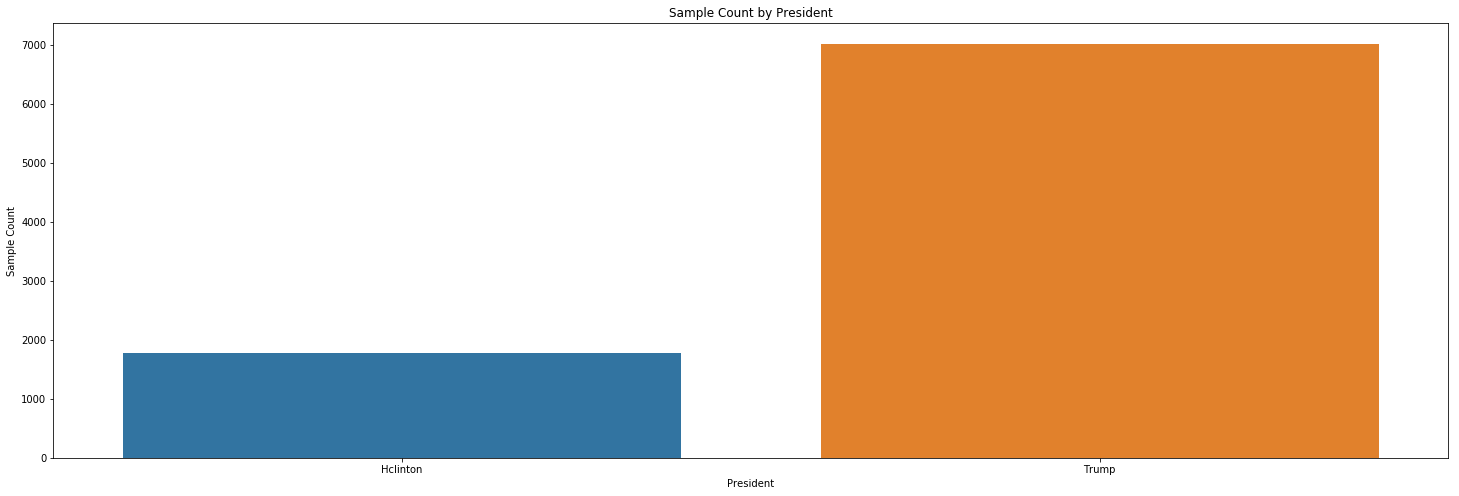

In [10]:
plt.figure(figsize=(25, 8))
sns.countplot('name', data=df)
plt.title(f'Sample Count by {df.columns[0].title()}')
plt.ylabel('Sample Count')
plt.xlabel(df.columns[0].title())
plt.show()

### Balance Dataset
Because it is clear that one individual has significantly more samples than the other, it is best to select a subset of samples equivalent to the total sample size of the less prominent individual. This could later prove to be problematic for presidents who gave a limited number of public appearances, as this could result in there not being enough samples to generate meaningful results. In this case, it is not expected to be a problem.

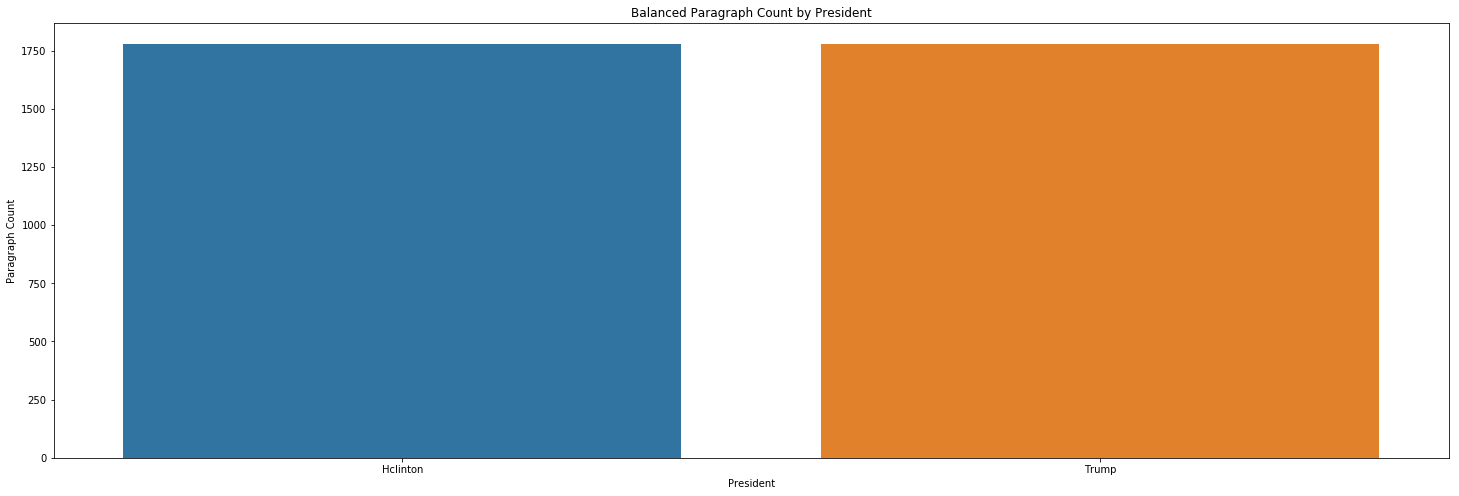

In [11]:
# Shuffle the Dataset.
shuffled_df = df.sample(frac=1)

# Create dictionary to store scaled dataframes for each president.
scaled_dfs = {}

# Set max samples based on president with fewest samples
n = shuffled_df.loc[shuffled_df['name'] == df['name'].value_counts().index[-1]].shape[0]

#Randomly select appropriate number of observations from the majority class
for name in df['name'].unique():
    scaled_dfs[f'{name}_df'] = shuffled_df.loc[shuffled_df['name'] == name].sample(n=n)

# Concatenate dataframes
scaled_dfs = [scaled_dfs[key] for key in list(scaled_dfs.keys())]
normalized_df = pd.concat(scaled_dfs)

#plot the dataset after the undersampling
plt.figure(figsize=(25, 8))
sns.countplot('name', data=normalized_df)
plt.title(f'Balanced Paragraph Count by {df.columns[0].title()}')
plt.ylabel('Paragraph Count')
plt.xlabel(df.columns[0].title())
plt.show()

In [12]:
normalized_df.shape

(3560, 5)

In [13]:
normalized_df.head()

,president,name,text,length,clean_text
153,0,Hclinton,As Maggie and Elizabeth and I were walking out...,56,"[maggie, elizabeth, walk, stage, lot, folk, ha..."
599,0,Hclinton,We had the worst economic collapse since the G...,80,"[bad, economic, collapse, since, great, depres..."
1554,0,Hclinton,That's my goal and that's what I'm going to do...,54,"[goal, go, every, thing, achieve, well, kristi..."
1732,0,Hclinton,And let's keep working for the ultimate goal o...,68,"[let, us, keep, work, ultimate, goal, make, po..."
1688,0,Hclinton,Our military is a national treasure. And a pre...,83,"[military, national, treasure, president, must..."


In [14]:
# Set variables for dependent and independent variables
target = normalized_df.president
data = normalized_df['clean_text'].values

### Create Bigrams
Certain terms may come up that make more sense together than independently (i.e. "United States", "North Korea", "Nuclear Weapon", etc). When terms are identified next to each other frequently, they may be combined into a single term using an underscore ("United_States"), making it easier for our network to deal with later on.

In [15]:
from gensim.models import phrases

# Identify and create bigrams
bigrams = phrases.Phrases(data)
bigrams_data = []

for i in range(len(data)):
    bigrams_data.append(bigrams[data[i]])
    
bigrams_data = np.array(bigrams_data)

# Get word count for longest sample after stop words removed and bigrams created
max_len = 0
for bigram in bigrams_data:
    max_len = len(bigram) if len(bigram) > max_len else max_len
    
print(f'Maximum Sample Word Count: {max_len}\n')
print(f"Sample:\n{' '.join([bigram for bigram in bigrams_data[0]])}")

Maximum Sample Word Count: 88

Sample:
maggie elizabeth walk stage lot folk hang window glad get good view also exciting two_week leave consequential_election lifetime


## 5. Vectorize Samples for Analysis Using GloVe
GloVe (short for Global Vectors Word Representation) is an open-source database of 6 billion pre-trained word vectors created by Stanford University. Rather than having to develop vector mapping for our entire vocabulary, theis database can be used to give our network a head start. Each unique word will be checked against the database to get only the vectors required for this specific dataset. Words and bigrams not found in the GloVe database will be assigned a zero vector and updated as part of the training process.

In [16]:
# Create variable to hold set of all unique words in sample corpus
total_vocabulary = set(word for text in bigrams_data for word in text)
print(f'Total Words in Vocabulary: {len(total_vocabulary)}')

Total Words in Vocabulary: 6868


In [17]:
# Create dictionary of vectors from GloVe based on total vocabulary
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    if word in total_vocabulary:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print(f'Total Words in Embedding Index: {len(embeddings_index)}')

Total Words in Embedding Index: 6054


In [18]:
class W2vVectorizer(object):
    # Assign GloVe vector to each word in vocabulary, or zero vector to words/bigrams not found
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(embeddings_index))])
    
    # Following required to allow for implementation of a fit method
    # Cannot be used in SKLearn Pipeline otherwise 
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

## 6. Benchmarking
Traditional machine learning methods are much less resource intensive than neural networks, so it should be expected that a neural network will outperform them. Random forest, support vector classification, and logistic regression will be used as potential benchmarks, with the top performing model being used as the benchmark against which neural network performance will be compared.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(embeddings_index)),
                ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True, n_jobs=-1))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(embeddings_index)),
                ('Support Vector Machine', SVC())])
lr  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(embeddings_index)),
                ('Logistic Regression', LogisticRegression(n_jobs=-1))])

In [20]:
models = [('Random Forest', rf),
          ("Support Vector Machine", svc),
          ("Logistic Regression", lr)]

In [21]:
# Use 2 cross-validations to gauge performance
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model in models]
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


[('Random Forest', 0.7851123595505618),
 ('Support Vector Machine', 0.7202247191011235),
 ('Logistic Regression', 0.7789325842696628)]

The top performing model is a random forest, with a score of 78.5%. We expect our neural networks to at least outperform this in order to justify their use.

## 7. Creating Neural Networks
### Import Libraries

In [22]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, GRU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, Conv1D, MaxPooling1D, Flatten
from keras.models import Model, Sequential, load_model
from keras.metrics import categorical_crossentropy
from keras.preprocessing import text
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


### Keras Tokenization & Sequencing
For use in Keras, bigram data must be re-tokenized as sequences numerical indices rather than words. By rejoining each sample's list of bigrams into a string, the Keras tokenizer can handle this quickly and easily. The total words in the vocabulary should match the previous count for benchmarking.

In [23]:
# Convert each sample's list of bigrams into a string
bigrams_joined = []

for bigrams in bigrams_data:
    bigrams_joined.append(' '.join(bigrams))

# Remove underscore from filters and no need to convert to lowercase
tokenizer = text.Tokenizer(filters='!"#%&()*+,./:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer.fit_on_texts(bigrams_joined)
sequences = tokenizer.texts_to_sequences(bigrams_joined)

word_index = tokenizer.word_index
print(f'Total Words in Vocabulary: {len(word_index)}')

Total Words in Vocabulary: 6868


The total word count of 6,915 matches the result from the previous tokenization process, which is a good indication that sequencing was successful was successful. 


### Padding
The neural network excpects each sample to be the same shape, however each sample is not the exact same length. A sequence of zeroes will be added to the end of each sample such that the length matches that of the longest sample in the corpus. 

Once padding and sequencing is completed, the original text and bigram data will be added as additional columns so that they can be retrieved by their respective indices later, allower for a more throrough analysis of the results later.

In [24]:
X_t = pad_sequences(sequences, maxlen=max_len, padding='post')
X_t_df = pd.DataFrame(X_t)
X_t_df['bigrams'] = bigrams_data
X_t_df['text'] = normalized_df.reset_index(drop=True)['text']
X_t_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,bigrams,text
0,954,1237,432,536,43,76,1694,2133,1323,7,...,0,0,0,0,0,0,0,0,"[maggie, elizabeth, walk, stage, lot, folk, ha...",As Maggie and Elizabeth and I were walking out...
1,89,288,3084,289,1416,4517,4518,84,4,104,...,0,0,0,0,0,0,0,0,"[bad, economic, collapse, since, great_depress...",We had the worst economic collapse since the G...
2,568,2,46,35,793,22,4521,1417,98,326,...,0,0,0,0,0,0,0,0,"[goal, go, every, thing, achieve, well, kristi...",That's my goal and that's what I'm going to do...
3,116,77,18,2136,568,13,444,53,144,1324,...,0,0,0,0,0,0,0,0,"[let_us, keep, work, ultimate, goal, make, pos...",And let's keep working for the ultimate goal o...
4,133,296,2440,49,235,160,334,770,80,1896,...,0,0,0,0,0,0,0,0,"[military, national, treasure, president, must...",Our military is a national treasure. And a pre...


In [25]:
# Set target variable
y = pd.get_dummies(target).values

### Train Test Split
Because the benchmark was calculated using 2-fold cross-validation (training and testing on half the data each time), the neural networks will be trained and tested in as similar a way as possible so as to maintain integrity of the results. Testing will be performed on half the data, while training will take place on the other half (validation split can be treated as a tunable hyperparameter).

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_t_df, y, test_size=.5)

X_train_text = X_train[['text', 'bigrams']]
X_train = X_train[X_train.columns[:-2]]

X_test_text = X_test[['text', 'bigrams']]
X_test = X_test[X_test.columns[:-2]]

### Vectorization & Embedding
While the embedding index created earlier should remain valid (mapping each word to a vector using GloVe), it is performed again here with the Keras generated tokens just as a precaution. However, while creating the embedding matrix, there will be one difference in that words not found in the GloVe index will be assigned random vectors rather than empty vectors since they represent weights that will be tuned as part of the training process.

In [27]:
# Create embedding index using GloVe
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [28]:
# Create matrix of random vectors which matches size of the word index
embedding_matrix = np.random.random((len(word_index) + 1, 100))
for word, i in word_index.items():
    
    # For each word found in the embedding index, assign the known vector
    embedding_vector = embeddings_index.get(word)
    
    # Otherwise, keep the randomly assigned vector
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1, 
                            100, weights = [embedding_matrix], 
                            input_length = max_len, trainable=True)

With the embedding matrix created, the search for a top performing neural network can begin.

### Network Development Strategy Synopsis
Convolutional Neural Networks (CNN) and Recurrent Neural Networks (RNN) have been shown to perform quite well for NLP classification tasks, and will therefore be used here in an attempt to identify the speakers of each sample. The two network architectures utilized here have been shown to perform well as a starting point for many NLP tasks, and allow for a significant amount of flexibility for adaptation. In addition to general architecture, the following strategies were implemented in building the network:

- **Grid Search:** Each network will be initialized with a function that utilizes the embedding layer already created, and will return the model, history, results, and processing time. All relevant hyperparameters (including number of epochs, validation split, etc.) are assigned default settings, and may be adjusted as desired by the user. A grid search will iterate through different combinations of hyperparameters searching for the minimum loss.

- **Loss vs Accuracy:** Through each epoch, the network will attempt to minimize the loss function. However, the best model will be selected based on its overall accuracy. This approach was selected in an effort to maintain alignment with Goodhart's Law, since accuracy is ultimately driven by the loss function.

- **Epochs & Early Stopping:** Each time the model is trained, it will be set to go through 100 epochs, but will stop if validation loss does not improve within 5 sequential epochs.

- **Checkpoints:** Because the total number of models generated can grow exponentially, it would be unrealistic to save each one to *.hdf5* for each set of hyperparameters. Instead, network accuracy and hyperparameters will be tracked, and the top performing model will be retrained so that predictions can be articulated. This is expected to result in small levels of variation within the results, but will nevertheless be reviewed at a later point to ensure the variations do not significantly impact the results. 


### Convolutional Network Architecture
The following function takes in a set of hyperparameters, and uses the existing embedding layer to create, train, and test a single convolutional neural network. It returns the model, model history, results, and total processing time.

In [29]:
def create_cnn_model(cdim=128, ksize=5, pool1=5, pool2=35, density=128, lr=.001, epochs=100, batch_size=128, validation_split=.3, patience=5, verbose=0):
    
    # Start Timer
    start = datetime.datetime.now()
    
    
    # Display Hyperparameter Settings
    print('Convolution Dimensions\tWindow Size\tPool 1\t\tPool 2\t\tDensity')
    print(f'{cdim}\t\t\t{ksize}\t\t{pool1}\t\t{pool2}\t\t{density}')
    
    
    # Build Model
    input_ = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = embedding_layer(input_)
    
    x = Conv1D(cdim, ksize, activation='relu')(embedded_sequences)
    x = MaxPooling1D(pool1, padding='same')(x)
    x = Conv1D(cdim, ksize, activation='relu')(x)
    x = MaxPooling1D(pool1, padding='same')(x)
    x = Conv1D(cdim, ksize, activation='relu')(x)
    x = MaxPooling1D(pool2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(density, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_, outputs=x)
    
    
    # Compile Model
    history = model.compile(loss='categorical_crossentropy', 
                            optimizer=Adam(lr=lr), 
                            metrics=['accuracy'])
    
    
    # Create Checkpoints & Stopping Parameters
    checkpoints_path = f'cnn_best_{p1}_{p2}.hdf5'
    checkpoint = ModelCheckpoint(checkpoints_path, 
                                 monitor='val_loss', 
                                 verbose=verbose, 
                                 save_best_only=True, 
                                 mode='min')
    
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   mode='min', 
                                   patience=patience)
    
    callbacks = [checkpoint, early_stopping]
    
    
    # Fit Model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=validation_split, 
                        callbacks=callbacks, 
                        verbose=verbose)
    
    # Evaluate Model
    results = model.evaluate(X_test, y_test)
    
    # End Timer
    end = datetime.datetime.now()
    
    # Display Results
    print(f'Time to Complete:\t{end - start}')
    print(f'Loss:\t{results[0]:.2f}\tAccuracy:\t{results[1]:.4f}\n')
    
    return model, history, results, end-start

### CNN Grid Search
**Defining the Grid:** Due to limited resources, the grid was set up to create a wide range of hyperparameters, while simultaneously attempting to limit the total number of combinations.
One item worth noting is that, depending on the minimum word count selected, some pooling and window sizes will not work properly. These instances will simply be skipped.

In [30]:
# Display total time elapsed since program started
t1 = datetime.datetime.now()
print(f'Time Elapsed: {t1 - t0}\n')

# Hyperparameter grid
cdims = [128, 256]
ksizes = [3, 5, 7]
pools1 = [3, 5, 7]
pools2 = [25, 35]
densities = [64, 128]

# Create dictionary for tracking CNN results and hyperparameters
cnn_results = {'Convolution Dimensions': [], 
               'Window Size': [], 
               'Pool 1': [], 
               'Pool 2': [], 
               'Density': [], 
               'Time': [], 
               'Loss': [], 
               'Accuracy': []}

for cdim in cdims:
    for ksize in ksizes:
        for pool1 in pools1:
            for pool2 in pools2:
                for density in densities:
                    
                    try:
                        cnn_model, cnn_history, cnn_eval, cnn_time = create_cnn_model(cdim=cdim, 
                                                                                      ksize=ksize, 
                                                                                      pool1=pool1, 
                                                                                      pool2=pool2, 
                                                                                      density=density)
                        cnn_results['Convolution Dimensions'].append(cdim)
                        cnn_results['Window Size'].append(ksize)
                        cnn_results['Pool 1'].append(pool1)
                        cnn_results['Pool 2'].append(pool2)
                        cnn_results['Density'].append(density)
                        cnn_results['Loss'].append(cnn_eval[0])
                        cnn_results['Accuracy'].append(cnn_eval[1])
                        cnn_results['Time'].append(cnn_time)
                        
                    except:
                        # If invalid hyperparameters, pass
                        pass
                    
t2 = datetime.datetime.now()
print(f'Time Elapsed: {t2 - t0}\n')
print(f'Time to Find Best Model: {t2 - t1}\n')

Time Elapsed: 0:02:31.479463

Convolution Dimensions	Window Size	Pool 1		Pool 2		Density
128			3		3		25		64
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
1780/1780 [==============================] - 0s 145us/step
Time to Complete:	0:00:11.164478
Loss:	0.46	Accuracy:	0.8607

Convolution Dimensions	Window Size	Pool 1		Pool 2		Density
128			3		3		25		128
1780/1780 [==============================] - 0s 147us/step
Time to Complete:	0:00:08.673361
Loss:	0.39	Accuracy:	0.8831

Convolution Dimensions	Window Size	Pool 1		Pool 2		Density
128			3		3		35		64
1780/1780 [==============================] - 0s 156us/step
Time to Complete:	0:00:08.590538
Loss:	0.38	Accuracy:	0.8916

Convolution Dimensions	Window Size	Pool 1		Pool 2		Density
128			3		3		35		128
1780/1780 [==============================] - 0s 148us/step
Time to Complete:	0:00:07.960181
Loss:	0.38	Accuracy:	0.8994

Convolution Dimensions	Window Size	Pool 1		Pool 2		D

### Train Best CNN Model
Identify the model with the highest accuracy score, and use the associated hyperparameters to retrain the model, displaying a greater level of detail in verbosity when training.

In [31]:
# Create dataframe from results dictionary
cnn_results_df = pd.DataFrame.from_dict(cnn_results)

# Get row values associated with highest accuracy
best_cnn_model = cnn_results_df[cnn_results_df['Accuracy'] == cnn_results_df['Accuracy'].max()]

# Save hyperparameters to variables
cdim = best_cnn_model['Convolution Dimensions'].values[0]
ksize = int(best_cnn_model['Window Size'].values[0])
pool1 = int(best_cnn_model['Pool 1'].values[0])
pool2 = int(best_cnn_model['Pool 2'].values[0])
density = int(best_cnn_model['Density'].values[0])

# Rebuild & retrain model with 
cnn_model, cnn_history, cnn_eval, cnn_time = create_cnn_model(cdim=cdim, 
                                                              ksize=ksize, 
                                                              pool1=pool1, 
                                                              pool2=pool2, 
                                                              density=density,
                                                              lr=.0001, 
                                                              epochs=100, 
                                                              patience=5, 
                                                              verbose=1)

t3 = datetime.datetime.now()
print(f'Time Elapsed: {t3 - t0}\n')
print(f'Time to Train Best Model: {t3 - t2}\n')

Convolution Dimensions	Window Size	Pool 1		Pool 2		Density
256			3		5		35		128
Train on 1246 samples, validate on 534 samples
Epoch 1/100
1246/1246 [==============================] - 4s 3ms/step - loss: 0.6178 - acc: 0.7881 - val_loss: 0.5639 - val_acc: 0.8539

Epoch 00001: val_loss improved from inf to 0.56393, saving model to cnn_best_hclinton_trump.hdf5
Epoch 2/100
1246/1246 [==============================] - 1s 743us/step - loss: 0.4149 - acc: 0.9928 - val_loss: 0.4210 - val_acc: 0.8951

Epoch 00002: val_loss improved from 0.56393 to 0.42104, saving model to cnn_best_hclinton_trump.hdf5
Epoch 3/100
1246/1246 [==============================] - 1s 760us/step - loss: 0.2216 - acc: 0.9992 - val_loss: 0.2957 - val_acc: 0.9139

Epoch 00003: val_loss improved from 0.42104 to 0.29571, saving model to cnn_best_hclinton_trump.hdf5
Epoch 4/100
1246/1246 [==============================] - 1s 752us/step - loss: 0.1000 - acc: 1.0000 - val_loss: 0.2131 - val_acc: 0.9251

Epoch 00004: val_loss imp

A test accuracy score of 91.7% is a good start, especially when compared to the benchmark score of 78.5%. The next step is to perform the same steps using a Recurrent Neural Network.

## Recurrent Network Architecture
The following function takes in a set of hyperparameters, and uses the existing embedding layer to create, train, and test a single convolutional neural network. It returns the model, model history, results, and total processing time.

**LSTM/GRU**: Unlike all other hyperparamters, the neuron type has an affect on the actual architecture of the network. The appropriate layer will be selected based on function input. While the default is set to *gru*, it should be noted that any other input will result in the model defaulting to *LSTM* and will not return an error.

**Bidirectional RNN**: Though more resource intensive, it was decided to use Bidirectional layers to improve accuracy.

In [32]:
def create_rnn_model(rnn_type='gru', units=50, drop=.5, density=50, lr=.001, epochs=100, batch_size=128, validation_split=.3, patience=5, verbose=0):
    
    # Start Timer
    start = datetime.datetime.now()
    
    
    # Display Hyperparameter Settings
    model_type = 'GRU' if rnn_type == 'gru' else 'LSTM'
    print(f'Model Type:\t{model_type}\tUnits:\t{units}\tDropout Rate:\t{drop}\t\tDensity: {density}')
    
    
    # Build Model
    input_ = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = embedding_layer(input_)
    
    if rnn_type == 'gru':
        x = Bidirectional(GRU(units, return_sequences=True))(embedded_sequences)
    else:
        x = Bidirectional(LSTM(units, return_sequences=True))(embedded_sequences)
        
    x = GlobalMaxPool1D()(x)
    x = Dropout(drop)(x)
    x = Dense(density, activation='relu')(x)
    x = Dropout(drop)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_, outputs=x)
    
    
    # Compile Model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=lr), 
                  metrics=['accuracy'])
    
    
    # Create Checkpoints & Stopping Parameters
    checkpoints_path = f'rnn_best_{p1}_{p2}.hdf5'
    checkpoint = ModelCheckpoint(checkpoints_path, 
                                 monitor='val_loss', 
                                 verbose=verbose, 
                                 save_best_only=True, 
                                 mode='min')
    
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   mode='min', 
                                   patience=patience)
    
    callbacks = [checkpoint, early_stopping]
    
    
    # Fit Model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=validation_split, 
                        callbacks=callbacks, 
                        verbose=verbose)
    
    # Evaluate Model
    results = model.evaluate(X_test, y_test)
    
    # End Timer
    end = datetime.datetime.now()
    
    # Display Results
    print(f'Time to Complete:\t{end - start}')
    print(f'Loss:\t{results[0]:.2f}\tAccuracy:\t{results[1]:.4f}\n')
    
    return model, history, results, end-start

### RNN Grid Search
To account for the additional time required to train a Bidirectional RNN, fewer combinations of hyperparameters were used than were for the Convolutional Network.

In [33]:
rnn_types = ['lstm', 'gru']
units = [25, 50]
drops = [.25, .5]
densities = [100, 150]

rnn_results = {'Model Type': [], 'Units': [], 'Dropout Rate': [], 'Density': [], 'Time': [], 'Loss': [], 'Accuracy': []}

for rnn_type in rnn_types:
    for unit in units:
        for drop in drops:
            for density in densities:
                rnn_model, rnn_history, rnn_eval, rnn_time = create_rnn_model(rnn_type=rnn_type, 
                                                                              units=unit, 
                                                                              drop=drop, 
                                                                              density=density)
                rnn_results['Model Type'].append(rnn_type)
                rnn_results['Units'].append(unit)
                rnn_results['Dropout Rate'].append(drop)
                rnn_results['Density'].append(density)
                rnn_results['Loss'].append(rnn_eval[0])
                rnn_results['Accuracy'].append(rnn_eval[1])
                rnn_results['Time'].append(rnn_time)
                
t4 = datetime.datetime.now()
print(f'Time Elapsed: {t4 - t0}\n')
print(f'Time to Find Best Model: {t4 - t3}\n')

Model Type:	LSTM	Units:	25	Dropout Rate:	0.25		Density: 100
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
1780/1780 [==============================] - 1s 392us/step
Time to Complete:	0:00:19.466354
Loss:	0.30	Accuracy:	0.9230

Model Type:	LSTM	Units:	25	Dropout Rate:	0.25		Density: 150
1780/1780 [==============================] - 1s 396us/step
Time to Complete:	0:00:19.745178
Loss:	0.34	Accuracy:	0.9191

Model Type:	LSTM	Units:	25	Dropout Rate:	0.5		Density: 100
1780/1780 [==============================] - 1s 405us/step
Time to Complete:	0:00:20.464555
Loss:	0.35	Accuracy:	0.9152

Model Type:	LSTM	Units:	25	Dropout Rate:	0.5		Density: 150
1780/1780 [==============================] - 1s 395us/step
Time to Complete:	0:00:20.651554
Loss:	0.39	Accuracy:	0.9169

Model Type:	LSTM	Units:	50	Dropout Rate:	0.25		Density: 100
1780/1780 [==============

### Train Best RNN Model
Identify the model with the highest accuracy score, and use the associated hyperparameters to retrain the model, displaying a greater level of detail in verbosity when training.

In [34]:
rnn_results_df = pd.DataFrame.from_dict(rnn_results)

best_rnn_model = rnn_results_df[rnn_results_df['Loss'] == rnn_results_df['Loss'].min()]

rnn_type = best_rnn_model['Model Type'].values[0]
units = int(best_rnn_model['Units'].values[0])
drop = float(best_rnn_model['Dropout Rate'].values[0])
density = int(best_rnn_model['Density'].values[0])

rnn_model, rnn_history, rnn_eval, rnn_time = create_rnn_model(rnn_type=rnn_type, 
                                                              units=units, 
                                                              drop=drop, 
                                                              density=density, 
                                                              lr=.001, 
                                                              epochs=100, 
                                                              patience=5, 
                                                              verbose=1)

t5 = datetime.datetime.now()
print(f'Time Elapsed: {t5 - t0}\n')
print(f'Time to Train Best Model: {t5 - t4}\n')

Model Type:	GRU	Units:	50	Dropout Rate:	0.25		Density: 100
Train on 1246 samples, validate on 534 samples
Epoch 1/100
1246/1246 [==============================] - 8s 7ms/step - loss: 0.5773 - acc: 0.6878 - val_loss: 0.3950 - val_acc: 0.9195

Epoch 00001: val_loss improved from inf to 0.39502, saving model to rnn_best_hclinton_trump.hdf5
Epoch 2/100
1246/1246 [==============================] - 1s 892us/step - loss: 0.2288 - acc: 0.9583 - val_loss: 0.2564 - val_acc: 0.9045

Epoch 00002: val_loss improved from 0.39502 to 0.25636, saving model to rnn_best_hclinton_trump.hdf5
Epoch 3/100
1246/1246 [==============================] - 1s 896us/step - loss: 0.0654 - acc: 0.9968 - val_loss: 0.1655 - val_acc: 0.9307

Epoch 00003: val_loss improved from 0.25636 to 0.16546, saving model to rnn_best_hclinton_trump.hdf5
Epoch 4/100
1246/1246 [==============================] - 1s 876us/step - loss: 0.0168 - acc: 0.9992 - val_loss: 0.1833 - val_acc: 0.9251

Epoch 00004: val_loss did not improve from 0.

### Visualize Results

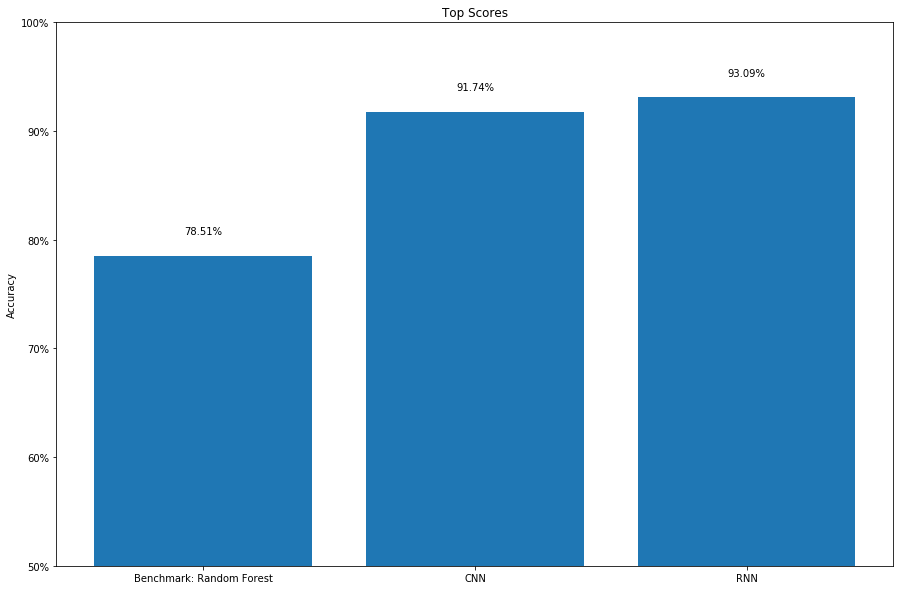

In [35]:
from operator import itemgetter

labels = [f'Benchmark: {max(scores,key=itemgetter(1))[0]}', 'CNN', 'RNN']
acc = [max(scores,key=itemgetter(1))[1], cnn_eval[1], rnn_eval[1]]

plt.figure(figsize = (15, 10))
plt.bar(labels, acc)
for i in range(3):
    plt.text(labels[i], acc[i] + .02, f'{np.round(acc[i]*100,2)}%', ha='center')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.yticks([i/10 for i in range(5, 11)], [f'{i*10}%' for i in range(5, 11)])
plt.title('Top Scores')
plt.show()

A Recurrent Neural Network with GRU memory cells is the top performing model, achieving a 93.1% accuracy rate, outperforming the CNN, and vastly outperforming the top benchmark. It will serve as our model for exploring results.

### Inspect Top Performing Model
#### Model Summary

In [36]:
top_models = {'rnn': rnn_model, 'cnn': cnn_model}
histories = {'rnn_hist': rnn_history, 'cnn_hist': cnn_history}
best = 'c' if cnn_eval[1] > rnn_eval[1] else 'r'
best_model = top_models[f'{best}nn']
best_model_hist = histories[f'{best}nn_hist']
print(f'Top Model Type: {best.upper()}NN')
best_model.summary()

Top Model Type: RNN
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_90 (InputLayer)        (None, 88)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 88, 100)           686900    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 88, 100)           45300     
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 100)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_34 (Dropout)         (None, 100)               0

#### Results History

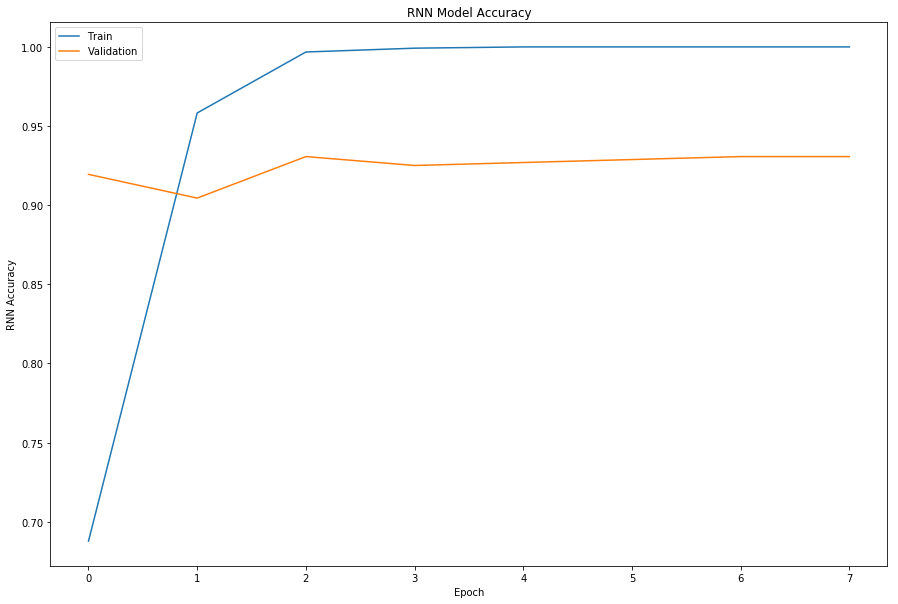

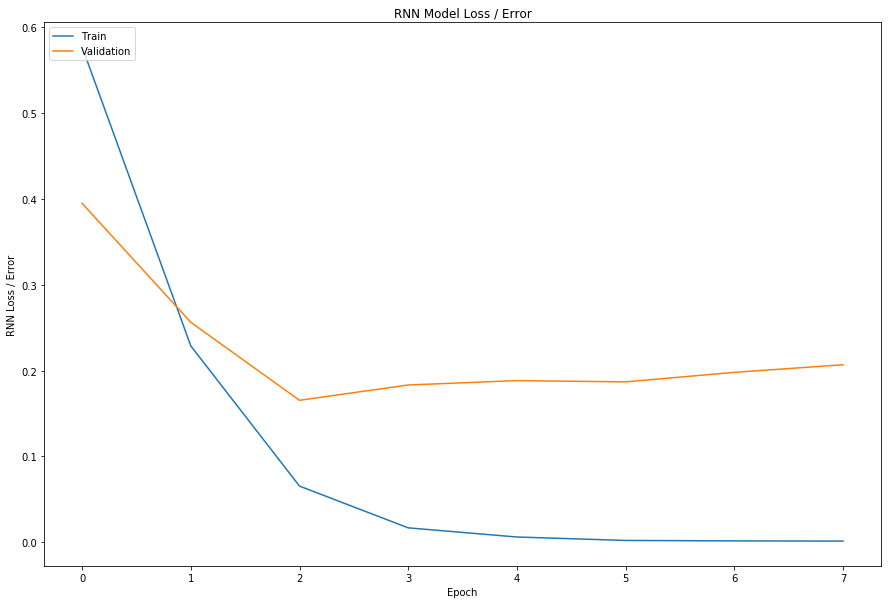

In [37]:
# Display history for accuracy
plt.figure(figsize=(15, 10))
plt.plot(best_model_hist.history['acc'])
plt.plot(best_model_hist.history['val_acc'])
plt.title(f'{best.upper()}NN Model Accuracy')
plt.ylabel(f'{best.upper()}NN Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Display history for loss
plt.figure(figsize=(15, 10))
plt.plot(best_model_hist.history['loss'])
plt.plot(best_model_hist.history['val_loss'])
plt.title(f'{best.upper()}NN Model Loss / Error')
plt.ylabel(f'{best.upper()}NN Loss / Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Despite being set at 100 epochs, the minimum validation loss score was found at the 3rd epoch, and training was stopped after 7 epochs.

### Predictions
Create a confusion matrix to inspect the number of accurate and inaccurate predictions.

In [38]:
from sklearn.metrics import confusion_matrix, f1_score
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
F1 Score: 93.08%


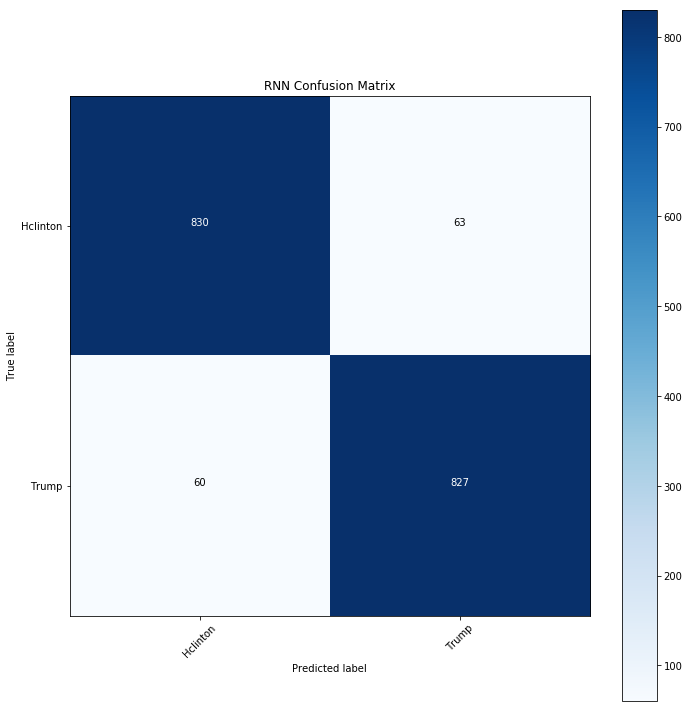

In [39]:
preds = np.argmax(best_model.predict(X_test), axis=1)
actual = np.argmax(y_test, axis=1)

cm = confusion_matrix(actual, preds)
cm_plot_labels = [p1.title(), p2.title()]

plot_confusion_matrix(cm, cm_plot_labels, normalize=False, title=f'{best.title()}NN Confusion Matrix')

print(f'F1 Score: {f1_score(actual, preds)*100:.2f}%')

Out of 1,780 predictions, the network made 123 errors. A slight majority of the errors were predictions that statements were made by Trump, when they were in fact made by Clinton. However, for this project, the direction of the error is of little consequence. Therefore, the F1-Score is being used as the primary metric.

## View List of Inaccurate Predictions

In [40]:
# Save all predictions to dataframe
preds_df = pd.DataFrame.from_dict({'Predictions': preds, 'Actual': actual})
preds_df = preds_df.join(X_test_text.reset_index(drop=True))

# Create column to indicate if the prediction matches the actual
# 0 = Clinton; 1 = Trump
preds_df['Accuracy'] = preds_df['Predictions'] == preds_df['Actual']
preds_df.head()

,Predictions,Actual,text,bigrams,Accuracy
0,0,0,"In 1955 they started, they were making auto pa...","[1955, start, make, auto, part, 2000, main, cu...",True
1,1,1,North Carolina will be at the very center of t...,"[north_carolina, center, effort, brand_new, ad...",True
2,1,1,It is a big problem. Real change also means re...,"[big_problem, real_change, also, mean_restore,...",True
3,1,1,"Far, far great than anybody ever thought. I ha...","[far, far, great, anybody, ever, think, great,...",True
4,1,1,"According to Heritage Foundation, by 2030, the...","[accord, heritage, foundation, 2030, obama, cl...",True


In [41]:
# Create dictionary for sorting predictions
word_counts = {f'{p1.title()}_Correct':[], 
               f'{p1.title()}_Incorrect':[], 
               f'{p2.title()}_Correct':[], 
               f'{p2.title()}_Incorrect':[]}

error_tracking = []

# Assign each text sample to dictionary
# Print actual speaker and text for each inaccurate prediction
for i in preds_df.index:
    if preds_df.iloc[i]['Actual'] == 0:
        if preds_df.iloc[i]['Accuracy'] == True:
            word_counts[f'{p1.title()}_Correct'] += preds_df.iloc[i]['bigrams']
        else:
            word_counts[f'{p1.title()}_Incorrect'] += preds_df.iloc[i]['bigrams']
            error_tracking += preds_df.iloc[i]['bigrams']
            print(f'{p1.title()}:')
            print(preds_df.iloc[i]['text'], '\n')
    else:
        if preds_df.iloc[i]['Accuracy'] == True:
            word_counts[f'{p2.title()}_Correct'] += preds_df.iloc[i]['bigrams']
        else:
            word_counts[f'{p2.title()}_Incorrect'] += preds_df.iloc[i]['bigrams']
            error_tracking += preds_df.iloc[i]['bigrams']
            print(f'{p2.title()}:')
            print(preds_df.iloc[i]['text'], '\n')

Trump:
I mean, who among us is? Is anybody totally proud of every single element? Some we are. But let me tell you what I'm very proud of. I'm proud that I've always treated the blue collar worker and I consider myself in a certain way to be a blue collar worker that make this country run with tremendous respect. 

Trump:
Thank you very much. And and leadership on this issue so very much. deeply invested in this long before the campaign began, I can tell you that. I'm very grateful to her for her work and efforts, and this proposal which we are going to outlining right way. And it going to make a lot of people very, very happy, a lot of moms very, very happy. 

Hclinton:
Donna Brazile is here, she's our acting chair of the DNC. So I I guess I'll leave it at that. I think I'm going to I'm going to respect the code of friendship silence but please know I've got a lot of great friends who have given me so much more. 

Trump:
ISIS is using the Internet to intercept and do all sorts of thin

### Sample Observations: Do errors highlight similarities?

The short answer is, "Not quite yet." It takes a while to go through all of the results, and in many cases it is difficult to understand how/why the algorithm got it wrong. But in some other cases, it's easier for us to understand:

***"But there are common sense things that your government could do that would give Americans more opportunities to succeed. Why don't we do it? Because powerful special interests and the tendency to put ideology ahead of political progress has led to gridlock in Congress. And how can you not be frustrated, and even angry, when you see nothing getting done? And a lot of people feel no one is on their side and no one has their back and that is not how it's supposed to be in America."***

Given what is known about Trump's campaign, and his desire to "drain the swamp," most could be forgiven for thinking Trump made the above statement. It seems that both Clinton and Trump are in agreement that politicians aren't adequately representing the interests of the people. However, not every error represents potential common ground areas, so a more systematic approach will be required to help identify themes. One such approach would be to use word clouds to identify frequently occurring terms in the data, helping to highlight areas to search.

### Visualizing the Differences with Word Clouds
The first step is to count the frequency with which each word is used by each candidate.

In [42]:
word_counts = {}

for key in word_index.keys():
    word_counts[key] = {p1: 0, p2: 0}
    
for i in range(preds_df.shape[0]):
    for word in preds_df.iloc[i]['bigrams']:
        selection = p1 if preds_df.iloc[i]['Actual'] == 0 else p2
        try:
            word_counts[word.lower()][selection]+=1
        except:
            pass
        
for key in list(word_counts.keys())[:5]:
    print(f'{key}: {word_counts[key]}')

not: {'hclinton': 620, 'trump': 776}
go: {'hclinton': 407, 'trump': 862}
he: {'hclinton': 525, 'trump': 225}
people: {'hclinton': 300, 'trump': 397}
say: {'hclinton': 292, 'trump': 404}


#### Calculate Word Usage Disparity
Rather than simply highlighting the most frequently used words by each candidate, it is more desireable to look at the words with the greatest disparity in ussage between the candidates on a percentage basis. The top 500 words with the greatest percentage disparity will be used.

*Note: when a word is used frequently by one candidate but never used by the other, 0.5 is subsituted for 0 when calculating the percentage to avoid null/undefined values.*

In [43]:
word_counts_df = pd.DataFrame.from_dict(word_counts).T
word_counts_df['difference'] = word_counts_df[p1] - word_counts_df[p2]
# word_counts_df['abs_difference'] = np.abs(word_counts_df['difference'])

# Replace 0 values with 0.5
word_counts_df = word_counts_df.replace(to_replace=0, value=.5)

word_counts_df[f'{p1}_portion'] = word_counts_df[p2] / word_counts_df[p1]
word_counts_df[f'{p2}_portion'] = word_counts_df[p1] / word_counts_df[p2]
word_counts_df['pct_diff'] = word_counts_df[[f'{p2}_portion', f'{p1}_portion']].max(axis=1)

# Reset 0.5 values to 0
word_counts_df = word_counts_df.replace(to_replace=.5, value=0)

word_cloud_df = word_counts_df.sort_values(by='pct_diff', ascending=False)[:1000]
word_cloud_df.head()

,hclinton,trump,difference,hclinton_portion,trump_portion,pct_diff
hillary,0.0,53.0,-53.0,106.0,0.009434,106.0
hillary_clinton,1.0,92.0,-91.0,92.0,0.010870,92.0
obamacare,0.0,45.0,-45.0,90.0,0.011111,90.0
border,0.0,34.0,-34.0,68.0,0.014706,68.0
medium,0.0,30.0,-30.0,60.0,0.016667,60.0


### Convert Word Counts to Word List String

In [44]:
p1, p2

('hclinton', 'trump')

In [45]:
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image as im
from PIL import Image

# Create list of words based on counts in dataframe
p1_cloud = []
p2_cloud = []

p1_word_cloud_df = word_cloud_df[word_cloud_df['difference'] > 0]
p2_word_cloud_df = word_cloud_df[word_cloud_df['difference'] < 0]

for i, w in enumerate(list(p1_word_cloud_df.index)):
    for j in range(int(list(p1_word_cloud_df[p1])[int(i)])):
        p1_cloud.append(w)
        
for i, w in enumerate(list(p2_word_cloud_df.index)):        
    for k in range(int(list(p2_word_cloud_df[p2])[int(i)])):
        p2_cloud.append(w)

# Words repeated in sequence cause them 
# to be duplicated in word cloud
# Shuffle lists to solve problem
np.random.shuffle(p1_cloud)
np.random.shuffle(p2_cloud)

# Convert lists to strings
p1_cloud = ', '.join(p1_cloud)
p2_cloud = ', '.join(p2_cloud)

# Create cloud for errors
error_cloud = []
for word in error_tracking:
    if len(word)>10: # in word_cloud_df.index[:500]:
        error_cloud.append(word)
error_cloud = ', '.join(error_cloud)  

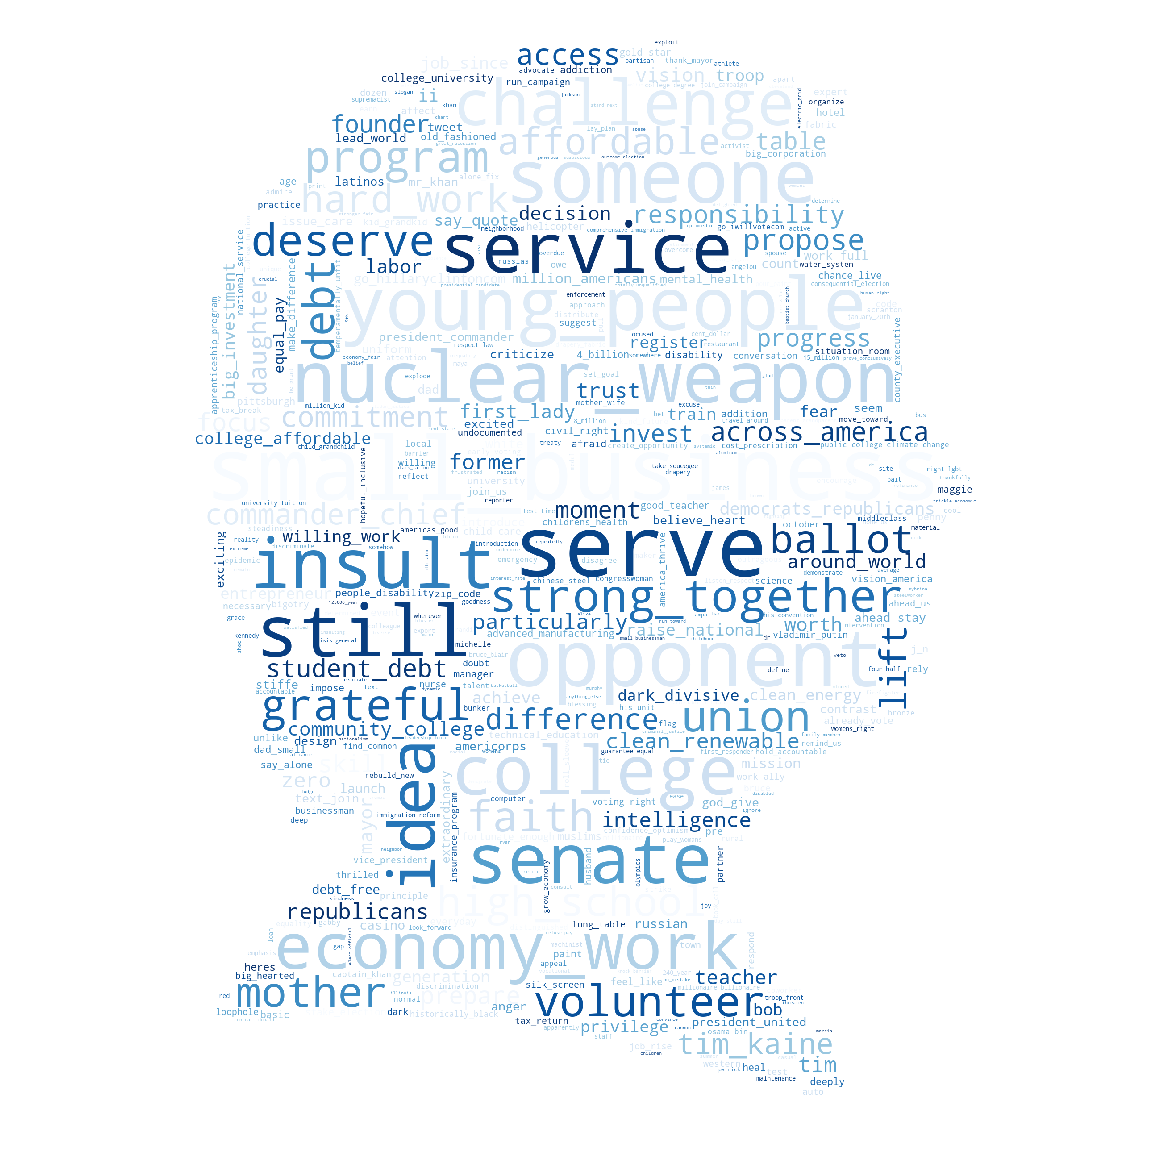

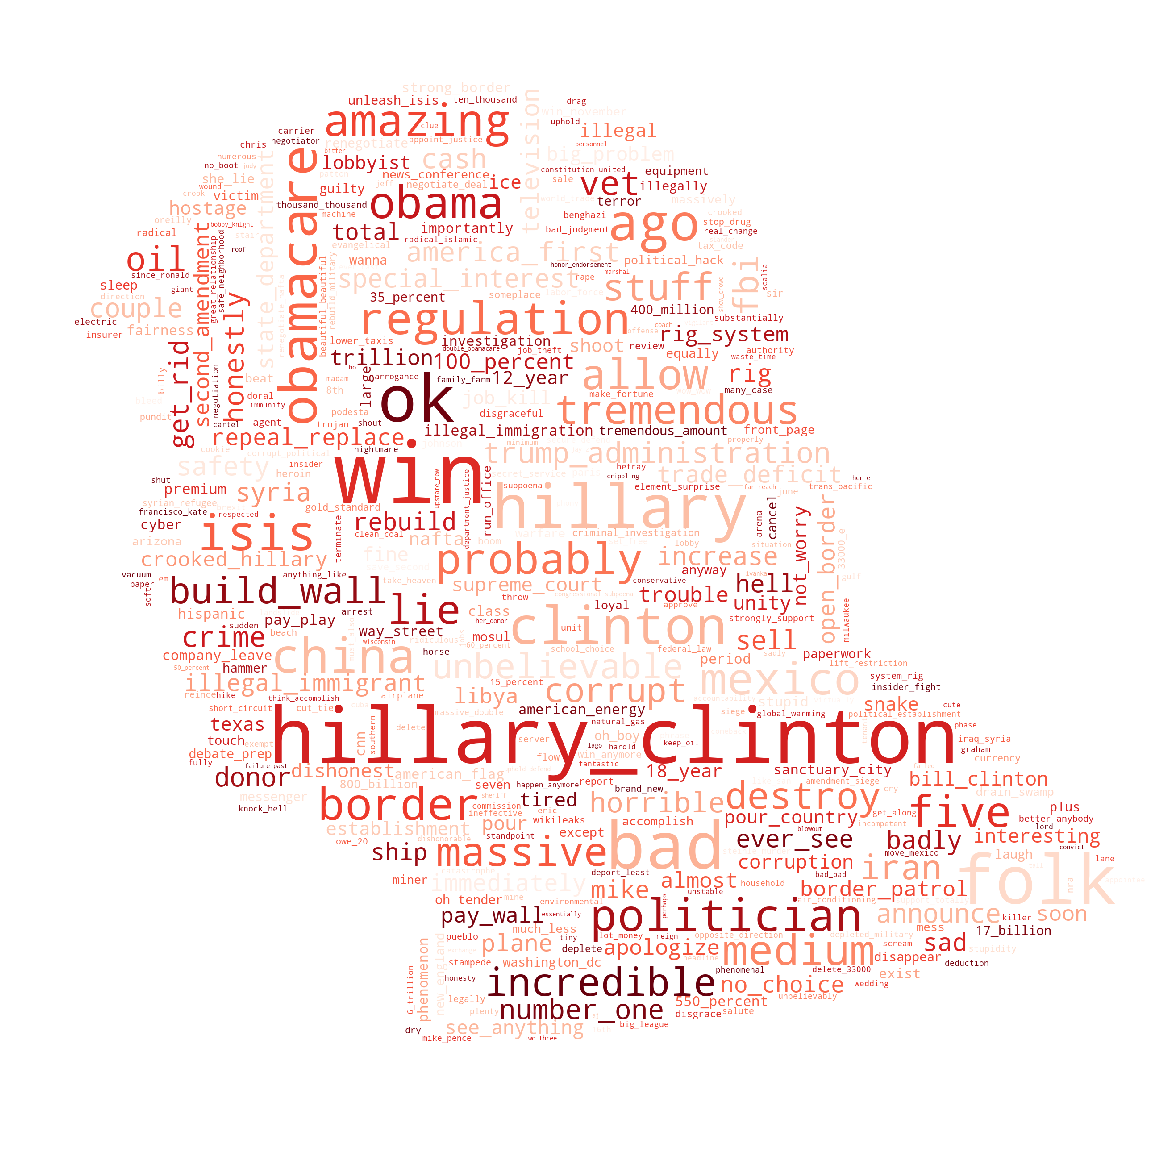

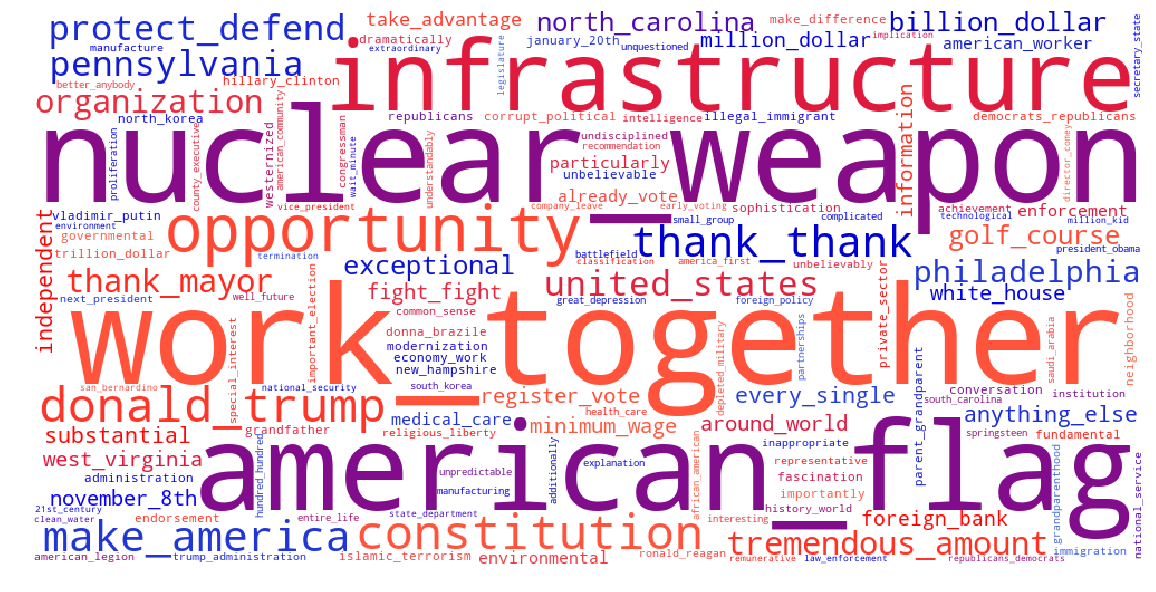

In [54]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["#FF0000", "#FF6347", "#DC143C", "#0000FF", "#0000CD", "#4169E1"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# Use Republican Elephant & Democratic Donkey as masks
p1_mask = np.array(Image.open('clinton_silhouette.png'))
p1_wc = WordCloud(background_color='white', colormap='Blues', mask=p1_mask, max_words=500)
p1_wc.generate(p1_cloud)

p2_mask = np.array(Image.open('trump_silhouette.png'))
p2_wc = WordCloud(background_color='white', colormap='Reds', mask=p2_mask, max_words=500)
p2_wc.generate(p2_cloud)

error_wc = WordCloud(background_color='white', colormap=cmap, max_words=500, width=1000, height=500)
error_wc.generate(error_cloud)

# Display word clouds
plt.figure(figsize=(20, 35))
plt.imshow(p1_wc)
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 35))
plt.imshow(p2_wc)
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 35))
plt.imshow(error_wc)
plt.axis('off')
plt.show()

In [47]:
T1 = datetime.datetime.now()
print(f'Time to Complete: {T1 - t0}\n')

Time to Complete: 0:16:57.149238



### Observations
We see that Donald Trump makes many direct references to Hillary and immigration, while Hillary Clinton talks a lot about small business, service (most likely in reference to her service in government), as well as young people (kid, young_people, high_school). And so this actually gives us some insight to better understand the errors. Have a look at the example provided earlier:

***"But there are common sense things that your government could do that would give Americans more opportunities to succeed. Why don't we do it? Because powerful special interests and the tendency to put ideology ahead of political progress has led to gridlock in Congress. And how can you not be frustrated, and even angry, when you see nothing getting done? And a lot of people feel no one is on their side and no one has their back and that is not how it's supposed to be in America."***

As one of the top 5 most common words found in the errors, "opportunity" lead to the discovery of the quote above. Searching for the term "infrastructure" leads to the following quote from Donald Trump:

***"And we're gonna use all of that money to invest in the infrastructure and we could even say the environmental infrastructure of our country. And remember this, remember this. When it comes to environment because I receive many environmental awards, you know, people don't wanna talk about that, that's OK. But we need absolutely crystal clear and clean water."***

Whether or not his words are to be accepted here is another topic of discussion, but if taken at face value, it would seem that the two actually have a shared interest in protecting the environment, though this doesn't say anything about what protecting the environment looks like for each of them respectfully.

The point here is that our network has an ability to shine a spotlight on the individuals in ways that allow us to uncover potential opportunities for collaboration in politics that might otherwise go unnoticed. 

## Conclusions & Next Steps
As a first run, it is encouraging to see accuracy scores over 90% when the network attempts to classify quotes to the appropriate speaker. Further refinement of the network should allow for even greater levels of accuracy, thus narrowing the aim and focus of the spotlight. At this point, however, only two individuals have been compared, so it will be important to see how well this approach fits for other combinations. Included in this repository are two other variants of this notebook, one of which compares [George Washington to Abraham Lincoln](./Washington_Lincoln.ipynb), and the other of which compares [Ronald Reagan to Barrack Obama](./Reagan_Obama.ipynb). Results can be found below:

**Washington vs Lincoln**<br>
-Model Type: CNN<br>
-Benchmark: 81.3%<br>
-F1 Score: 84.3%<br>

**Reagan vs Obama**<br>
-Model Type: RNN with GRU Memory Cells<br>
-Benchmark: 74.8%<br>
-F1 Score: 87.6%

With varying levels of accuracy and different network architectures selected, it is apparent that not all presidents can be so easily distinguished from one another, nor in the same manners. However, it would not be efficient to run a grid search each time we want to compare two presidents; lack of efficiency would be further exascerbated when comparing more than 2 individuals at a time. In order to get a sense of what type of model architecture and hyperparameters would provide the best general performance, a database of results would required. As such, the [student2.ipynb](./student2.ipynb) file in this repository represents the first steps to building such a database.